### Imports

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.express as px

import xgboost as xgb

from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.linear_model import LogisticRegression
from sklearn import tree

from sklearn.metrics import log_loss, roc_auc_score, accuracy_score

from sklearn import preprocessing

### Data ingest

In [2]:
# dataset reference: https://www.kaggle.com/datasets/muhakabartay/sloan-digital-sky-survey-dr16/code
df = pd.read_csv('./data_sdss16/Skyserver_12_30_2019 4_49_58 PM.csv')

print(df.shape)
print(df.columns)
df.head(3)

(100000, 18)
Index(['objid', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'rerun', 'camcol',
       'field', 'specobjid', 'class', 'redshift', 'plate', 'mjd', 'fiberid'],
      dtype='object')


,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1237666301628060000,47.372545,0.820621,18.69254,17.13867,16.55555,16.34662,16.17639,4849,301,5,771,8168632633242440000,STAR,0.000115,7255,56597,832
1,1237673706652430000,116.303083,42.455980,18.47633,17.30546,17.24116,17.32780,17.37114,6573,301,6,220,9333948945297330000,STAR,-0.000093,8290,57364,868
2,1237671126974140000,172.756623,-8.785698,16.47714,15.31072,15.55971,15.72207,15.82471,5973,301,1,13,3221211255238850000,STAR,0.000165,2861,54583,42


### Data prep

In [3]:
df['class'].value_counts()

GALAXY    51323
STAR      38096
QSO       10581
Name: class, dtype: int64

### Create binary classification version of dataset

In [4]:
df2 = df[ (df['class'] == 'STAR') | (df['class'] == 'GALAXY')]
df2 = df2.reset_index(drop=True)

In [5]:
print(df.shape, df2.shape)

(100000, 18) (89419, 18)


In [6]:
df2['class'].value_counts()

GALAXY    51323
STAR      38096
Name: class, dtype: int64

### Create feature matrix (X) and target (y) for machine learning model building

In [7]:
print(df2.columns)
df2.head(3)

Index(['objid', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'rerun', 'camcol',
       'field', 'specobjid', 'class', 'redshift', 'plate', 'mjd', 'fiberid'],
      dtype='object')


,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1237666301628060000,47.372545,0.820621,18.69254,17.13867,16.55555,16.34662,16.17639,4849,301,5,771,8168632633242440000,STAR,0.000115,7255,56597,832
1,1237673706652430000,116.303083,42.455980,18.47633,17.30546,17.24116,17.32780,17.37114,6573,301,6,220,9333948945297330000,STAR,-0.000093,8290,57364,868
2,1237671126974140000,172.756623,-8.785698,16.47714,15.31072,15.55971,15.72207,15.82471,5973,301,1,13,3221211255238850000,STAR,0.000165,2861,54583,42


In [8]:
/#df_X = df2[[ 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'redshift']]
df_X = df2[[ 'ra', 'dec', 'u']]
df_y = df2[['class']]

In [9]:
le = preprocessing.LabelEncoder()
le.fit(df_y['class'])
df_y['categorical_label'] = le.transform(df_y['class'])

df_y['class'] = df_y['categorical_label']
df_y = df_y[['class']]

# note: le.inverse_transform(df['categorical_label'])

<ipython-input-9-fa768822bfc9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y['categorical_label'] = le.transform(df_y['class'])
<ipython-input-9-fa768822bfc9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y['class'] = df_y['categorical_label']


In [10]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3)

### For reference: gradient boosted tree (XGBoost) Model

In [1]:
clf_xgb = xgb.XGBClassifier()
clf_xgb.fit(X_train, y_train)

In [12]:
y_xgb_pred = clf_xgb.predict(X_test)
y_xgb_pred_proba = clf_xgb.predict_proba(X_test)[:, 1]

In [13]:
accuracy_xgb = accuracy_score(y_test, y_xgb_pred)
print(accuracy_xgb)

0.7459926936554089


In [14]:
auc_xgb = roc_auc_score(y_true=y_test.values, y_score=y_xgb_pred_proba)

In [15]:
ls_model = []
ls_auc = []

ls_model = ls_model + ['XGBoost']
ls_auc = ls_auc + [auc_xgb]

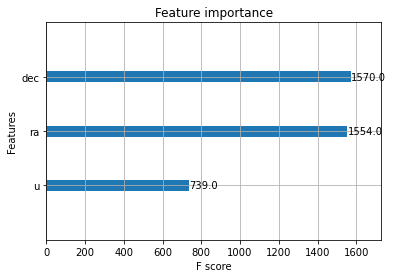

In [16]:
xgb.plot_importance(clf_xgb);

### Implement a weighted average ensembling strategy based on inverse model covariance

In [17]:
#model_1 = SVC(probability=True, random_state=0)
model_1 = tree.DecisionTreeClassifier()
#model_2 = RandomForestClassifier()
#model_2 = KNeighborsClassifier()
model_2 = GaussianNB()
model_3 = LogisticRegression()

In [18]:
ls_model = ls_model + ['Decision Tree', 'Naive Bayes', 'Logistic Regression']

ls_model

['XGBoost', 'Decision Tree', 'Naive Bayes', 'Logistic Regression']

In [19]:
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)

C:\Users\m85302\Anaconda3b\envs\seqDarts1\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\m85302\Anaconda3b\envs\seqDarts1\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [20]:
y_pred1 = model_1.predict(X_test)
y_pred2 = model_2.predict(X_test)
y_pred3 = model_3.predict(X_test)

In [21]:
y_proba_pred1 = model_1.predict_proba(X_test)[:,1]
y_proba_pred2 = model_2.predict_proba(X_test)[:,1]
y_proba_pred3 = model_3.predict_proba(X_test)[:,1]

In [22]:
accuracy1 = accuracy_score(y_test, y_pred1)
accuracy2 = accuracy_score(y_test, y_pred2)
accuracy3 = accuracy_score(y_test, y_pred3)
print(accuracy1, accuracy2, accuracy3)

0.6958174904942965 0.6503392231417282 0.623909639901588


In [23]:
roc_auc_1 = roc_auc_score(y_test, y_proba_pred1)
roc_auc_2 = roc_auc_score(y_test, y_proba_pred2)
roc_auc_3 = roc_auc_score(y_test, y_proba_pred3)
print(roc_auc_1, roc_auc_2, roc_auc_3)

0.6895986118104658 0.6933989273925523 0.6302292729012295


In [24]:
ls_auc = ls_auc + [roc_auc_1, roc_auc_2, roc_auc_3]

print(ls_model)
print(ls_auc)

['XGBoost', 'Decision Tree', 'Naive Bayes', 'Logistic Regression']
[0.8077430096505664, 0.6895986118104658, 0.6933989273925523, 0.6302292729012295]


#### Implement the inverse-covariance weighted average ensembling scheme

In [25]:
proba = np.stack([model_1.predict_proba(X_test)[:, 1],
                  model_2.predict_proba(X_test)[:, 1],
                  model_3.predict_proba(X_test)[:, 1]]).T

In [26]:
cormat = np.corrcoef(proba.T)
np.fill_diagonal(cormat, 0.0)
W = 1 / np.mean(cormat, axis=1)
W = W / sum(W) # normalizing to sum==1.0
weighted = proba.dot(W)
ras = roc_auc_score(y_true=y_test, y_score=weighted)
print(f"Weighted averaging ROC-AUC is: {ras:0.5f}")

Weighted averaging ROC-AUC is: 0.74675


In [27]:
ls_model = ls_model + ['Weighted Avg']
ls_auc = ls_auc + [ras]

ls_model
ls_auc

[0.8077430096505664,
 0.6895986118104658,
 0.6933989273925523,
 0.6302292729012295,
 0.746753856623394]

In [28]:
print(ls_model)

['XGBoost', 'Decision Tree', 'Naive Bayes', 'Logistic Regression', 'Weighted Avg']


In [29]:
df_result = pd.DataFrame({'Model': ls_model,
                          'ROC-AUC': ls_auc
                         })
df_result = df_result.sort_values(by='ROC-AUC')
df_result = df_result.reset_index(drop=True)

df_result

,Model,ROC-AUC
0,Logistic Regression,0.630229
1,Decision Tree,0.689599
2,Naive Bayes,0.693399
3,Weighted Avg,0.746754
4,XGBoost,0.807743


In [30]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.2f}'.format(p.get_height()) # '{:.1f}' #2f # {:.2f}
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5) # 0.5
                #_y = p.get_y() + p.get_height() - (p.get_height()*0.75)
                value = '{:.3f}'.format(p.get_width())  # '{:.1f}' # 2f # '{:.3f}'
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

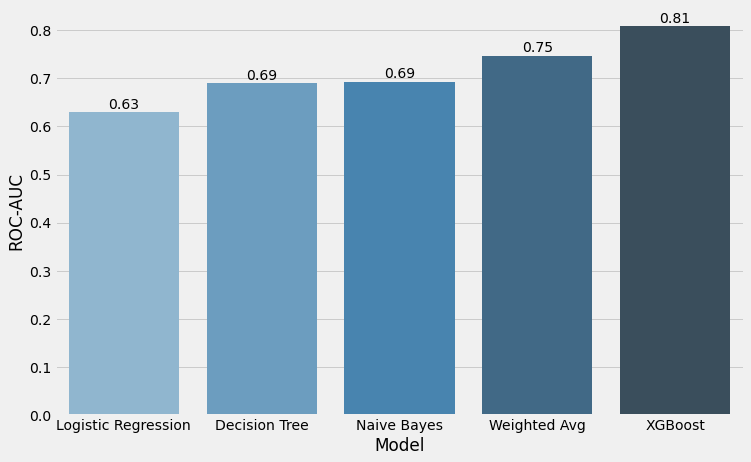

In [32]:
plt.figure(figsize=(11,7))
plt.style.use('fivethirtyeight')
plt1 = sns.barplot(x='Model', y='ROC-AUC', data=df_result, palette="Blues_d")
plt1 = show_values(plt1)

We see that while the inverse-covariance weighted average ensembling strategy does improve over the performacne of the 3 models alone, the ensembling and normalization strategies incorporated in XGBoost prove to provide superior performance overall